# Tutorial

## Introduction

This tutorial demonstrates the steps to simulate hydrodynamic potentials and compute coefficients using the `MEEMEngine` and related modules. 

We will:
1. Assemble a linear system.
2. Solve it to find coefficients.
3. Visualize hydrodynamic potentials and velocities.

## Setup

### Required Modules

Ensure the following libraries are installed:

- Python 3.x
- NumPy
- SciPy
- Matplotlib
- Pandas

Also, you must include the following custom modules:
``equations``, ``constants``, ``geometry``, ``meem_engine``, and ``meem_problem``.

## Code Structure

The main script follows these steps:

1. Import necessary modules.
2. Define parameters for the domain.
3. Create `Geometry`, `MEEMProblem`, and `MEEMEngine` objects.
4. Compute coefficients and visualize results.

## Code Walkthrough

### 1. **Import Libraries**
Here's how to import required libraries and set up paths:

Import Required Libraries

In [34]:
import sys
import os
import numpy as np
import pandas as pd
from scipy import linalg
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Add the source path to the system path
src_path = os.path.abspath(os.path.join(os.path.dirname("__file__"), '../package/src'))
sys.path.append(src_path)


In [35]:
from equations import *
from constants import *
from meem_engine import MEEMEngine
from meem_problem import MEEMProblem
from geometry import Geometry

# Set printing options for NumPy
np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)

**Note:** Ensure the `src` directory contains all the required modules.

### 2. **Define Parameters**
Define the simulation parameters, including the number of harmonics and domain properties:


Define Constants and Multi-Region Parameters

In [36]:
from multi_constants import *
from multi_equations import *

NMK = [30, 30, 30]  # Adjust these values as needed
boundary_count = len(NMK) - 1

Create Domain Parameters

In [37]:
# Create domain parameters
domain_params = []
for idx in range(len(NMK)):
    params = {
        'number_harmonics': NMK[idx],
        'height': h - d[idx] if idx < len(d) else h,
        'radial_width': a[idx] if idx < len(a) else a[-1]*1.5,
        'top_BC': None,
        'bottom_BC': None,
        'category': 'multi',  # Adjust category as needed
        'di': d[idx] if idx < len(d) else 0,
        'a': a[idx] if idx < len(a) else a[-1]*1.5,
        'heaving': heaving[idx] if idx < len(heaving) else False,
        'slant': [0, 0, 1]  # Set True if the region is slanted
    }
    domain_params.append(params)

### 3. **Create Objects**
Set up the `Geometry`, `MEEMProblem`, and `MEEMEngine` objects:

Create Geometry and Problem Objects

In [38]:
# Create Geometry object
r_coordinates = {'a': a}
z_coordinates = {'h': h}
geometry = Geometry(r_coordinates, z_coordinates, domain_params)

# Create MEEMProblem object
problem = MEEMProblem(geometry)

### 4. **Assemble and Solve**
Assemble the linear system and solve for coefficients:

Create MEEMEngine and Assemble Matrices

In [39]:
# Create MEEMEngine object
engine = MEEMEngine([problem])

# Assemble A matrix and b vector using multi-region methods
A = engine.assemble_A_multi(problem)
b = engine.assemble_b_multi(problem)

Solve the Linear System and Compute Hydrodynamic Coefficients

In [40]:
# Solve the linear system A x = b
X = linalg.solve(A, b)

# Compute hydrodynamic coefficients
hydro_coefficients = engine.compute_hydrodynamic_coefficients(problem, X)

# Print hydrodynamic coefficients
print("Hydrodynamic Coefficients:")
for key, value in hydro_coefficients.items():
    print(f"{key}: {value}")

[0.02351559+0.j 0.06279153+0.j]
Hydrodynamic Coefficients:
hydro_coef: (1.5637357110637748+1.1523375596273402j)
hydro_coef_real: 1604.505538020095
hydro_coef_imag: 3232.760334266271
hydro_coef_nondim: (0.4992472875742309+0.3679019395307493j)


/var/folders/y0/9n1rj1dx3md8kwg6n8jblkzm0000gn/T/ipykernel_70088/1204308439.py:2: LinAlgWarning: Ill-conditioned matrix (rcond=6.5447e-36): result may not be accurate.
  X = linalg.solve(A, b)


Split Cs into Groups by Equation

In [41]:
Cs = []
row = 0
Cs.append(X[:NMK[0]])
row += NMK[0]
for i in range(1, boundary_count):
    Cs.append(X[row: row + NMK[i] * 2])
    row += NMK[i] * 2
Cs.append(X[row:])

Define Potential Functions

In [42]:
def phi_h_n_inner_func(n, r, z):
    return (Cs[0][n] * R_1n(n, r, 0)) * Z_n_i(n, z, 0)

def phi_h_m_i_func(i, m, r, z):
    return (Cs[i][m] * R_1n(m, r, i) + Cs[i][NMK[i] + m] * R_2n(m, r, i)) * Z_n_i(m, z, i)

def phi_e_k_func(k, r, z):
    return Cs[-1][k] * Lambda_k(k, r) * Z_n_e(k, z)


Set Up Spatial Resolution and Grid

In [43]:
spatial_res = 50
r_vec = np.linspace(2 * a[-1] / spatial_res, 2 * a[-1], spatial_res)
z_vec = np.linspace(-h, 0, spatial_res)

# Add values at the radii
a_eps = 1.0e-4
for i in range(len(a)):
    r_vec = np.append(r_vec, a[i] * (1 - a_eps))
    r_vec = np.append(r_vec, a[i] * (1 + a_eps))
r_vec = np.unique(r_vec)

for i in range(len(d)):
    z_vec = np.append(z_vec, -d[i])
z_vec = np.unique(z_vec)

R, Z = np.meshgrid(r_vec, z_vec)

In [44]:
regions = []
regions.append((R <= a[0]) & (Z < -d[0]))
for i in range(1, boundary_count):
    regions.append((R > a[i-1]) & (R <= a[i]) & (Z < -d[i]))
regions.append(R > a[-1])

Calculate Homogeneous and Particular Potentials

In [45]:
phi = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 

# Homogeneous potential calculation
for n in range(NMK[0]):
        temp_phiH = phi_h_n_inner_func(n, R[regions[0]], Z[regions[0]])
        phiH[regions[0]] = temp_phiH if n == 0 else phiH[regions[0]] + temp_phiH

for i in range(1, boundary_count):
    for m in range(NMK[i]):
        temp_phiH = phi_h_m_i_func(i, m, R[regions[i]], Z[regions[i]])
        phiH[regions[i]] = temp_phiH if m == 0 else phiH[regions[i]] + temp_phiH

for k in range(NMK[-1]):
    temp_phiH = phi_e_k_func(k, R[regions[-1]], Z[regions[-1]])
    phiH[regions[-1]] = temp_phiH if k == 0 else phiH[regions[-1]] + temp_phiH

# Add particular potential (if applicable)
phi_p_i_vec = np.vectorize(phi_p_i)

phiP[regions[0]] = heaving[0] * phi_p_i_vec(d[0], R[regions[0]], Z[regions[0]])
for i in range(1, boundary_count):
    phiP[regions[i]] = heaving[i] * phi_p_i_vec(d[i], R[regions[i]], Z[regions[i]])
phiP[regions[-1]] = 0

phi = phiH + phiP

### 5. **Visualization**
Generate plots for the computed potentials:

Visualize Potentials

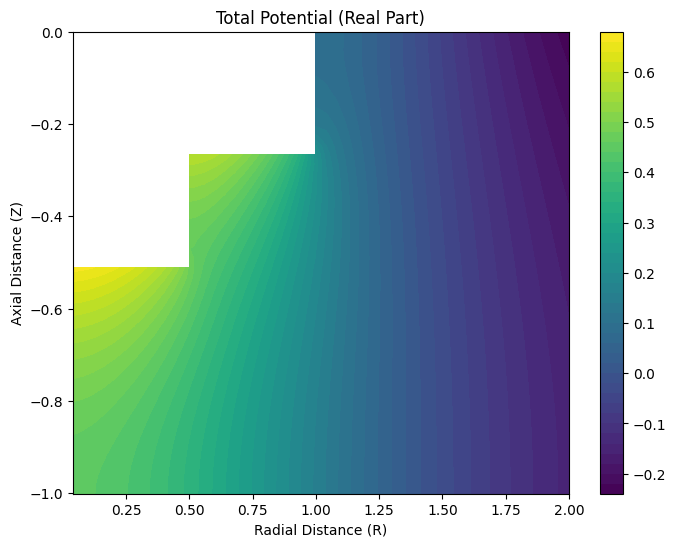

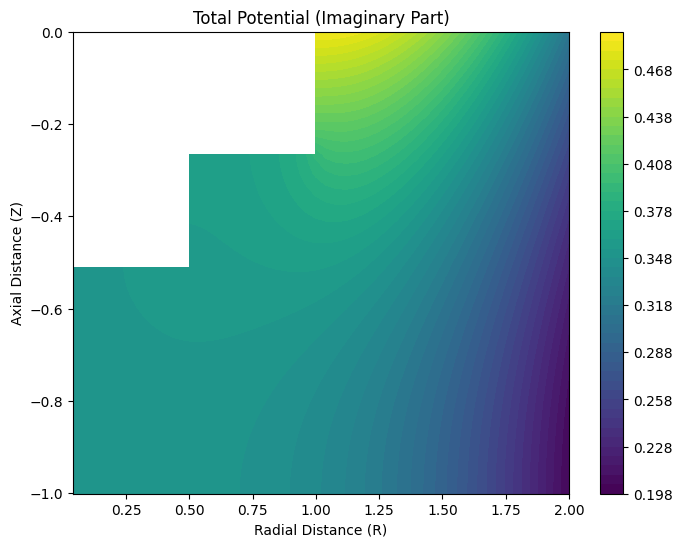

In [46]:
def plot_potential(field, R, Z, title):
    plt.figure(figsize=(8, 6))
    plt.contourf(R, Z, field, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

plot_potential(np.real(phi), R, Z, 'Total Potential (Real Part)')
plot_potential(np.imag(phi), R, Z, 'Total Potential (Imaginary Part)')

## Conclusion
This tutorial walks through MEEM simulations using `MEEMEngine`. You can also customize boundary conditions or explore additional visualizations.